# **Propose methods are CNNs, RNNs and CTC loss.**

So, for this implementation we are going to talk about only CTC (Connectionist Temporal Classification) loss.

> *Connectionist Temporal Classification (CTC) is a type of Neural Network output helpful in tackling sequence problems like handwriting and speech recognition where the timing varies. Using CTC ensures that one does not need an aligned dataset, which makes the training process more straightforward.*

---

<img src='https://miro.medium.com/max/1400/1*i2OG4hu9EjsyWcVMc4OOvA.png'>

---

CTC is simply a loss function that is used to train Neural Networks, like Cross-Entropy and so on. It is used at problems, where having aligned data is an issue, like Speech Recognition.

With CTC, there is no need for aligned data. That is because it can assign a probability for any label, given an input. This means it only requires an audio file as input and a corresponding transcription.  But how can CTC assign a probability for any label, just given an input? Like I said, CTC is "alignment-free“. It works by summing over the probability of all possible alignments between the input and the label.  

---
**How CTC works**

As already discussed, we don’t want to annotate the images at each horizontal position (which we call time-step from now on). The NN-training will be guided by the CTC loss function. We only feed the output matrix of the NN and the corresponding ground-truth (GT) text to the CTC loss function. But how does it know where each character occurs? Well, it does not know. Instead, it tries all possible alignments of the GT text in the image and takes the sum of all scores. This way, the score of a GT text is high if the sum over the alignment-scores has a high value.

---

CTC works on the following three major concepts:
- Encoding the text
- Loss calculation
- Decoding
***

**Encoding the Text**

The issue with methods not using CTC is, what to do when the character takes more than one time-step in the image? Non-CTC methods would fail here and give duplicate characters.

To solve this issue, CTC merges all the repeating characters into a single character. For example, if the word in the image is ‘hey’ where ‘h’ takes three time-steps, ‘e’ and ‘y’ take one time-step each. Then the output from the network using CTC will be ‘hhhey’, which as per our encoding scheme, gets collapsed to ‘hey’.

Now this question arises: What about the words where there are repeating characters? For handling those cases, CTC introduces a pseudo-character called blank denoted as “-“ in the following examples. While encoding the text, if a character repeats, then a blank is placed between the characters in the output text. Let’s consider the word ‘meet’, possible encodings for it will be, ‘mm-ee-ee-t’, ‘mmm-e-e-ttt’, wrong encoding will be ‘mm-eee-tt’, as it’ll result in ‘met’ when decoded. The CRNN is trained to output the encoded text.

---

**Loss calculation**

We need to calculate the loss value for the training samples (pairs of images and GT texts) to train the NN. You already know that the NN outputs a matrix containing a score for each character at each time-step. A minimalistic matrix is shown in Figure where there are two time-steps (t0, t1) and three characters (“a”, “b” and the blank “-”). The character-scores sum to 1 for each time-step.
<img src = 'https://miro.medium.com/max/800/1*BFQYgGofh6HOxnGdkJnO-w.png'>


Further, you already know that the loss is calculated by summing up all scores of all possible alignments of the GT text, this way it does not matter where the text appears in the image.

The score for one alignment (or path, as it is often called in the literature) is calculated by multiplying the corresponding character scores together. In the example shown above, the score for the path “aa” is 0.4·0.4=0.16 while it is 0.4·0.6=0.24 for “a-” and 0.6·0.4=0.24 for “-a”. To get the score for a given GT text, we sum over the scores of all paths corresponding to this text. Let’s assume the GT text is “a” in the example: we have to calculate all possible paths of length 2 (because the matrix has 2 time-steps), which are: “aa”, “a-” and “-a”. We already calculated the scores for these paths, so we just have to sum over them and get 0.4·0.4+0.4·0.6+0.6·0.4=0.64. If the GT text is assumed to be “--”, we see that there is only one corresponding path, namely “--”, which yields the overall score of 0.6·0.6=0.36.

We are now able to compute the probability of the GT text of a training sample, given the output matrix produced by the NN. The goal is to train the NN such that it outputs a high probability (ideally, a value of 1) for correct classifications. Therefore, we maximize the product of probabilities of correct classifications for the training dataset. For technical reasons, we re-formulate into an equivalent problem: minimize the loss of the training dataset, where the loss is the negative sum of log-probabilities. If you need the loss value for a single sample, simply compute the probability, take the logarithm, and put a minus in front of the result. To train the NN, the gradient of the loss with respect to the NN parameters (e.g., weights of convolutional kernels) is computed and used to update the parameters.

---
**Decoding**

Once CRNN gets trained, we want it to give us output on unseen text images. Putting it differently, we want the most likely text given an output matrix of the CRNN. One method can be to examine every potential text output, but it won’t be very practical to do from a computation point of view. The best path algorithm is used to overcome this issue.

It consists of the following two steps:
- Calculates the best path by considering the character with max probability at every time-step.
- This step involves removing blanks and duplicate characters, which results in the actual text.
For example, let us consider the matrix in Fig.3. If we consider the first time-step t0, then the character with maximum probability is ‘b’. For t1 and t2 character with maximum probability is ‘-‘ and ‘-‘ respectively. So, the output text according to the best path algorithm for matrix in Figure after decoding is ‘b’.

---

Resources:

- [Medium Blog](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)

- [Siddhant's Scratch Book](https://sid2697.github.io/Blog_Sid/algorithm/2019/10/19/CTC-Loss.html?fbclid=IwAR2llk4Fb-yDLRESV4LluXan7zDsHNVt_rgWqxM6IhTMDZ5poVEDZwtzI2g)

- [Machine Learning -- Blog](https://machinelearning-blog.com/2018/09/05/753/)

---

Let's build the model for reading Captchas

[Keras Documentation](https://keras.io/examples/vision/captcha_ocr/)

[Kaggle Competition](https://www.kaggle.com/fournierp/captcha-version-2-images)

In [3]:
#importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Load the Dataset

The dataset contains 1040 captcha files as png images. The label for each sample is a string, the name of the file (minus the file extension). We will map each character in the string to an integer for training the model. Similary, we will need to map the predictions of the model back to strings. For this purpose we will maintain two dictionaries, mapping characters to integers, and integers to characters, respectively.

In [4]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    484      0 --:--:-- --:--:-- --:--:--   484
100 8863k  100 8863k    0     0  5518k      0  0:00:01  0:00:01 --:--:-- 30.4M


In [5]:
#Set the path to the data directory 
data_dir = Path("./captcha_images_v2/")

#Getting the data
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f'The Number of Images: ',len(images))
print(f'The Number of Labels: ',len(labels))
print(f'The Number of unique Characters : ',len(characters))
print(f'characters have: ',characters)

The Number of Images:  1040
The Number of Labels:  1040
The Number of unique Characters :  19
characters have:  {'p', 'b', 'm', '7', 'd', '3', '4', '2', 'g', '6', '5', 'y', 'c', 'w', 'e', 'f', '8', 'n', 'x'}


In [50]:
#set the batch size , epochs

batch_size = 16

#image Dimension
img_width =  200
img_height = 50

downsample_factor = 4
'''Factor by which the image is going to be downsampled
by the convolutional blocks. We will be using two
convolution blocks and each block will have
a pooling layer which downsample the features by a factor of 2.
Hence total downsampling factor would be 4.
Maximum length of any captcha in the dataset'''

max_length = max([len(label) for label in labels])

In [15]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [34]:
#get the shape of the data

x_train , y_train , x_valid , y_valid = split_data(np.array(images),
                                                   np.array(labels))

print(f"X_Train shape: {x_train.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"X_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_Train shape: (14, 200, 50, 1)
y_Train shape: (2, 200, 50, 1)
X_valid shape: (14, 5)
y_valid shape: (2, 5)


In [16]:
#Create a dataset objects
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample,num_parallel_calls = tf.data.experimental.AUTOTUNE
    ).batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

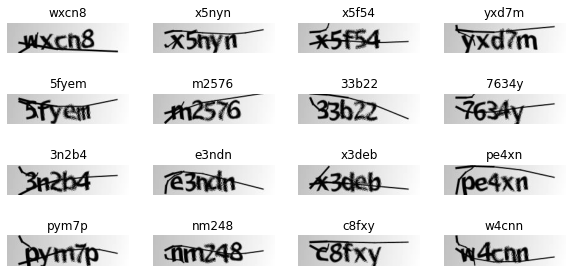

In [21]:
#Visual the Data
_,ax = plt.subplots(4,4,figsize=(10,5))
for batch in train_dataset.take(1):
  images = batch["image"]
  labels = batch["label"]
  for i in range(16):
    img = (images[i]*255).numpy().astype("uint8")
    label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    ax[i // 4, i%4].imshow(img[:,:,0].T , cmap = "gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()

In [22]:
#Model
#https://www.tensorflow.org/api_docs/python/tf/cast
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

Traning 

In [26]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
#model.fit apply
history = model.fit(train_dataset , validation_data=validation_dataset
                    ,epochs = epochs,
                    callbacks =[early_stopping])

Epoch 1/100
59/59 [==============================] - 41s 58ms/step - loss: 31.5661 - val_loss: 16.3792
Epoch 2/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3699 - val_loss: 16.3585
Epoch 3/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3668 - val_loss: 16.3585
Epoch 4/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3613 - val_loss: 16.3639
Epoch 5/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3481 - val_loss: 16.3575
Epoch 6/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3259 - val_loss: 16.3201
Epoch 7/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3054 - val_loss: 16.2718
Epoch 8/100
59/59 [==============================] - 2s 32ms/step - loss: 16.2559 - val_loss: 16.2721
Epoch 9/100
59/59 [==============================] - 2s 33ms/step - loss: 16.1856 - val_loss: 16.1458
Epoch 10/100
59/59 [==============================] - 2s 32ms/step - loss: 16.073

**Inference**

In [41]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            4921

In [51]:
# A utility function to decode the output of the network
#http://tensorflow.biotecan.com/python/Python_1.8/tensorflow.google.cn/api_docs/python/tf/keras/backend/ctc_decode.html
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)


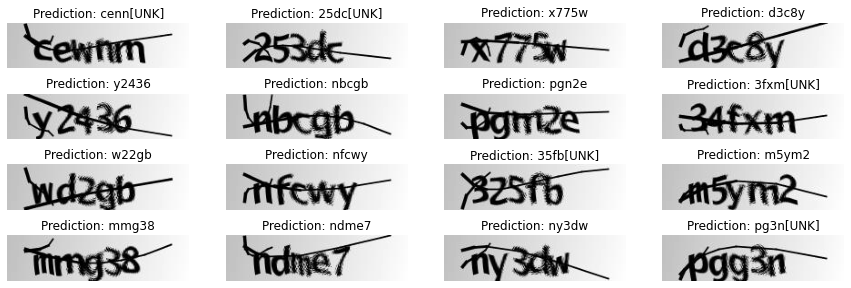

In [52]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(len(pred_texts)):
      img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
      img = img.T
      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap="gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")        
plt.show()

**END**